In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import spacy

In [3]:
df = pd.read_csv("taylor_swift_lyrics.csv",encoding = "latin1")

In [20]:
df.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [6]:
df.shape

(4862, 7)

In [8]:
#albums does not inclue folklore
df.album.unique()

array(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989',
       'reputation'], dtype=object)

In [14]:
#start off looking at a whole song?
num_songs = len(df.track_title.unique())
print(f'there are {num_songs} songs in the dataset')

there are 94 songs in the dataset


In [15]:
#avg lines in all song
df.describe('track')

,track_n,line,year
count,4862.000000,4862.000000,4862.000000
mean,8.216989,28.426573,2011.882764
std,4.696379,18.343649,3.571447
min,1.000000,1.000000,2006.000000
25%,4.000000,13.000000,2010.000000
50%,8.000000,26.000000,2012.000000
75%,12.000000,41.000000,2014.000000
max,19.000000,101.000000,2017.000000


In [48]:
# lets look at hist of songs by total lines
df.groupby('track_title',as_index=False)['line'].count()

,track_title,line
0,...Ready for It?,61
1,22,53
2,A Perfectly Good Heart,23
3,A Place In This World,27
4,All Too Well,47
...,...,...
89,Wildest Dreams,58
90,Wonderland,67
91,You Are in Love,45
92,You Belong With Me,49


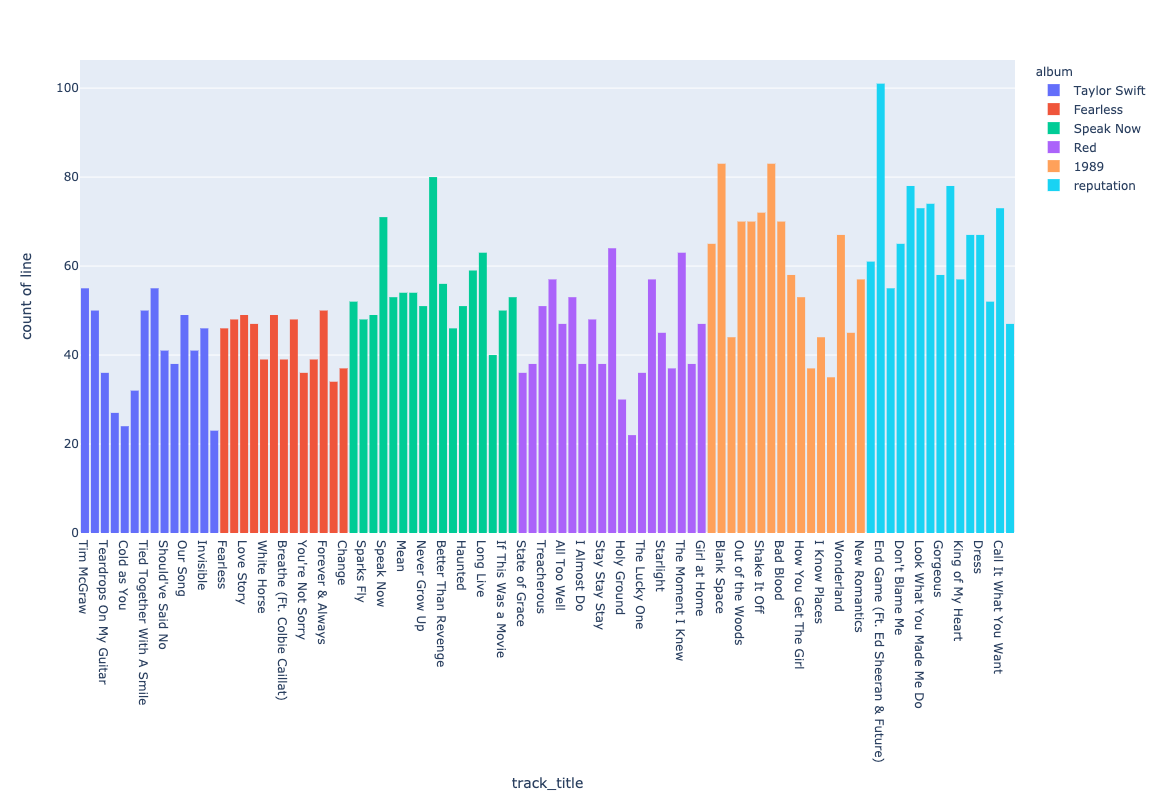

In [72]:

px.histogram(df,x='track_title',y='line',color='album',histfunc='count',orientation='v',height=800)

In [ ]:
#leads me to think i can have a complezxity of song metric? total words/num lines?

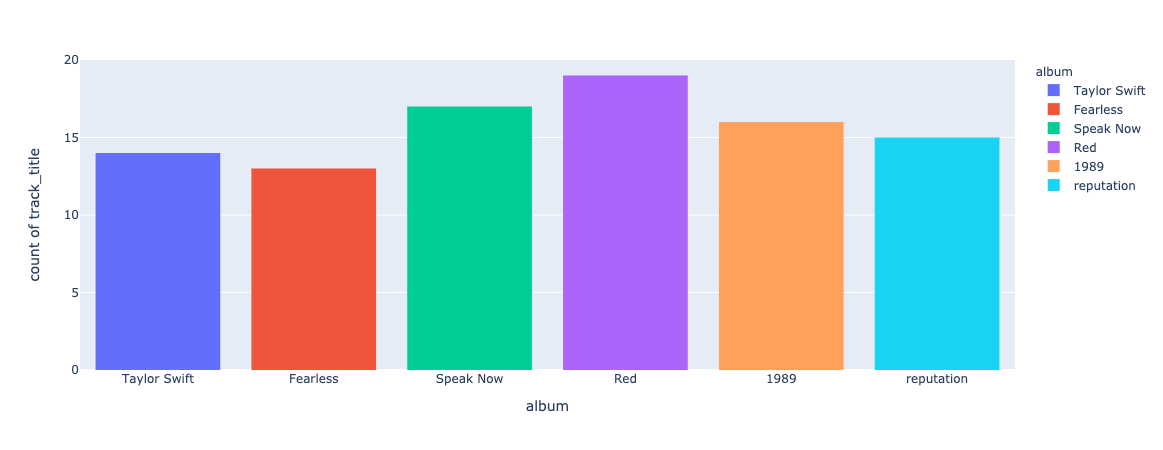

In [78]:
px.histogram(df.drop_duplicates(subset=['track_title']),x='album',y='track_title',color='album',histfunc='count',orientation='v')

In [129]:
#now lets look at the lyrics!

nlp = spacy.load('en_core_web_lg')

In [197]:
from functools import reduce

def concat_lyrics(series):
    return reduce(lambda x, y: x + " " + y, series)

In [199]:
lyrics_album = df.groupby('album',as_index=False).agg({'lyric': concat_lyrics})

In [202]:
# have all tokens now seperated by album
lyrics_album['tokens'] = lyrics_album.lyric.apply(lambda x: nlp(x))

In [208]:
lyrics_album

,album,lyric,tokens
0,1989,"Walking through a crowd, the village is aglow ...","(Walking, through, a, crowd, ,, the, village, ..."
1,Fearless,There's something 'bout the way The street loo...,"(There, 's, something, 'bout, the, way, The, s..."
2,Red,I'm walking fast through the traffic lights Bu...,"(I, 'm, walking, fast, through, the, traffic, ..."
3,Speak Now,"You were in college, working part-time, waitin...","(You, were, in, college, ,, working, part, -, ..."
4,Taylor Swift,He said the way my blue eyes shined Put those ...,"(He, said, the, way, my, blue, eyes, shined, P..."
5,reputation,Knew he was a killer first time that I saw him...,"(Knew, he, was, a, killer, first, time, that, ..."


In [211]:
albums = list(lyrics_album.album.values)
lyrics_album.album.values

array(['1989', 'Fearless', 'Red', 'Speak Now', 'Taylor Swift',
       'reputation'], dtype=object)

0    (Walking, through, a, crowd, ,, the, village, ...
1    (There, 's, something, 'bout, the, way, The, s...
2    (I, 'm, walking, fast, through, the, traffic, ...
3    (You, were, in, college, ,, working, part, -, ...
4    (He, said, the, way, my, blue, eyes, shined, P...
5    (Knew, he, was, a, killer, first, time, that, ...
Name: tokens, dtype: object

In [269]:
import collections

f = []
temp = lyrics_album.set_index('album')
for i, album in enumerate(albums):
    print(album)
    d = (list(filter(lambda x: x.is_stop==False,temp.loc[album].tokens)))
    d = (list(filter(lambda x: x.is_punct==False, d)))
    d = (list(map(lambda x: x.lemma_, d)))
    
    c = collections.Counter(d)
    
    word_counts = pd.DataFrame(c.items())
    word_counts.columns = ['word','count']
    word_counts['album'] = album
    
    f.append(word_counts)
    

1989
Fearless
Red
Speak Now
Taylor Swift
reputation


In [268]:
temp = lyrics_album.set_index('album')
type(temp.loc['1989'].tokens)

spacy.tokens.doc.Doc

In [271]:
counts_per

,word,count,album
0,walk,3,1989
1,crowd,2,1989
2,village,1,1989
3,aglow,1,1989
4,Kaleidoscope,1,1989
...,...,...,...
650,wrong,2,reputation
651,memory,9,reputation
652,stranger,4,reputation
653,recognize,4,reputation


In [270]:
counts_per = pd.concat(f)

In [272]:
counts_per.sort_values('count', ascending=False, inplace=True)

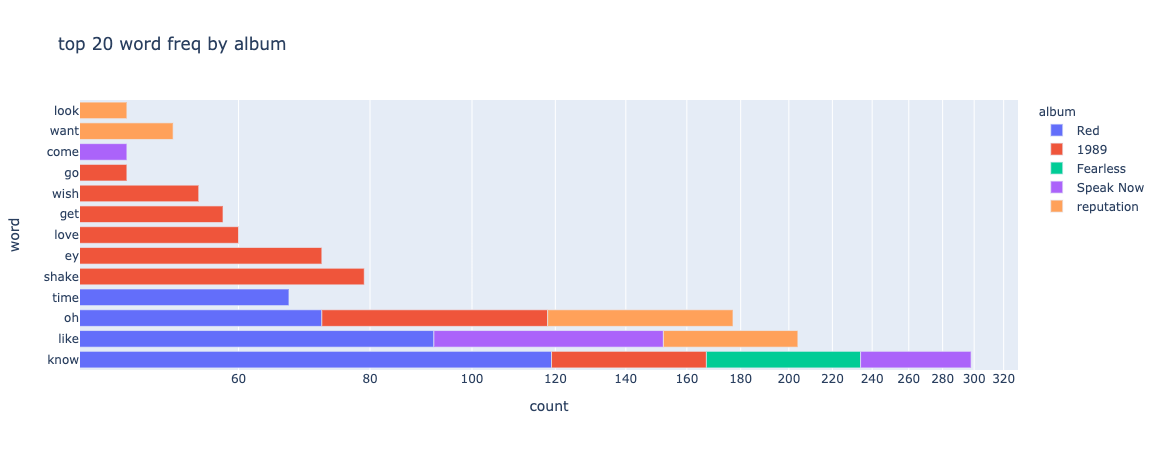

In [273]:
px.bar(counts_per[:20], x="count", y="word", color="album", orientation='h',title="top 20 word freq by album", log_x=True)
